In [33]:
import numpy as np
import pandas as pd
import os
import sys

from utils import select_ores_greedy
import matplotlib.pyplot as plt
# plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] 
# %matplotlib inline

import pickle
import cv2
import scipy
from scipy.stats import pearsonr

import importlib
# from classifiers import R_from_path
%config InlineBackend.figure_format = 'png' 

In [2]:
import requests
from bs4 import BeautifulSoup
from scipy.interpolate import interp1d, PchipInterpolator
import csv

In [35]:
from scipy.optimize import lsq_linear, LinearConstraint, minimize

In [45]:
with open('input_0219_0224_0225.pkl', 'rb') as f:
    input_all = pickle.load(f)
pixels = input_all[0]
data = input_all[1]

## get mu values from nist

In [13]:
def fetch_mu_rho(element_symbol):
    """
    Fetches mass attenuation coefficients (μ/ρ) for a given element at specified energies.

    Parameters:
    - element_symbol: str, chemical symbol of the element (e.g., 'Fe')
    - energies_keV: list or array of energies in keV

    Returns:
    - mu_rho_values: list of μ/ρ values corresponding to the input energies
    """
    # Mapping of element symbols to atomic numbers
    symbol_to_atomic_number = {
        'H': 1, 'He': 2, 'Li': 3, 'Be': 4, 'B': 5, 'C': 6, 'N': 7, 'O': 8, 'F': 9, 'Ne': 10,
        'Na': 11, 'Mg': 12, 'Al': 13, 'Si': 14, 'P': 15, 'S': 16, 'Cl': 17, 'Ar': 18, 'K': 19, 'Ca': 20,
        'Sc': 21, 'Ti': 22, 'V': 23, 'Cr': 24, 'Mn': 25, 'Fe': 26, 'Co': 27, 'Ni': 28, 'Cu': 29, 'Zn': 30,
        'Ga': 31, 'Ge': 32, 'As': 33, 'Se': 34, 'Br': 35, 'Kr': 36, 'Rb': 37, 'Sr': 38, 'Y': 39, 'Zr': 40,
        'Nb': 41, 'Mo': 42, 'Tc': 43, 'Ru': 44, 'Rh': 45, 'Pd': 46, 'Ag': 47, 'Cd': 48, 'In': 49, 'Sn': 50,
        'Sb': 51, 'Te': 52, 'I': 53, 'Xe': 54, 'Cs': 55, 'Ba': 56, 'La': 57, 'Ce': 58, 'Pr': 59, 'Nd': 60,
        'Pm': 61, 'Sm': 62, 'Eu': 63, 'Gd': 64, 'Tb': 65, 'Dy': 66, 'Ho': 67, 'Er': 68, 'Tm': 69, 'Yb': 70,
        'Lu': 71, 'Hf': 72, 'Ta': 73, 'W': 74, 'Re': 75, 'Os': 76, 'Ir': 77, 'Pt': 78, 'Au': 79, 'Hg': 80,
        'Tl': 81, 'Pb': 82, 'Bi': 83, 'Po': 84, 'At': 85, 'Rn': 86, 'Fr': 87, 'Ra': 88, 'Ac': 89, 'Th': 90,
        'Pa': 91, 'U': 92
    }

    atomic_number = symbol_to_atomic_number.get(element_symbol)
    if atomic_number is None:
        raise ValueError(f"Element symbol '{element_symbol}' is not recognized.")

    # Construct the URL for the element's data page
    url = f"https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z{atomic_number:02d}.html"

    # Fetch the page content
    response = requests.get(url)
    if response.status_code != 200:
        raise ConnectionError(f"Failed to retrieve data for {element_symbol} from NIST.")

    # Parse the HTML content
    soup = BeautifulSoup(response.text, 'html.parser')
    pre_tag = soup.find('pre')
    if not pre_tag:
        raise ValueError(f"No data table found for {element_symbol}.")

    # Extract data lines
    lines = pre_tag.text.strip().split('\n')
    data_lines = []
    for line in lines:
        if line.strip() and not line.startswith(('E', '---')):
            data_lines.append(line.strip())

    # Parse the data into arrays
    energies = []
    mu_rho = []
    for line in data_lines:
        parts = line.split()
        if len(parts) >= 2:
            try:
                energy = float(parts[0])
                mu = float(parts[1])
                energies.append(energy)
                mu_rho.append(mu)
            except ValueError:
                continue  # Skip lines that don't contain valid floats

    # # Interpolate to get μ/ρ at desired energies
    # interpolator = interp1d(energies, mu_rho, kind='linear', bounds_error=False, fill_value="extrapolate")
    # mu_rho_values = interpolator(energies_keV)

    return energies, mu_rho


def save_mu_rho_to_csv(element_symbol, save_dir='nist_data'):
    """
    Fetch and save full μ/ρ vs energy data for an element to a local CSV file.
    """
    os.makedirs(save_dir, exist_ok=True)
    # 用 fetch_mu_rho 内部逻辑拉全表

    full_energies, mu_rho_values = fetch_mu_rho(element_symbol)

    filename = os.path.join(save_dir, f"{element_symbol}_mu_rho.csv")
    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Energy_MeV', 'Mu_over_rho_cm2_per_g'])
        for e, mu in zip(full_energies, mu_rho_values):
            writer.writerow([e, mu])
    print(f"[+] Saved μ/ρ data for {element_symbol} to {filename}")


def get_mu_rho(element_symbol, energies_MeV, data_dir='nist_data'):
    """
    Return μ/ρ values for an element at given energies.
    优先从本地读取，如无则爬取并保存，最终插值返回目标能量的μ/ρ。
    """
    filepath = os.path.join(data_dir, f"{element_symbol}_mu_rho.csv")
    if not os.path.exists(filepath):
        print(f"[i] μ/ρ data for {element_symbol} not found locally. Fetching from NIST...")
        save_mu_rho_to_csv(element_symbol, save_dir=data_dir)
    
    # 加载本地数据
    energies = []
    mu_rho = []
    with open(filepath, 'r') as f:
        next(f)  # skip header
        for line in f:
            e, mu = map(float, line.strip().split(','))
            energies.append(e)
            mu_rho.append(mu)

    interpolator = interp1d(energies, mu_rho, kind='linear', bounds_error=False, fill_value="extrapolate")
    return np.array(energies), np.array(mu_rho), interpolator(energies_MeV)



In [5]:
for elem in ['Fe', 'Zn', 'Pb', 'S', 'Si', 'O']:
    save_mu_rho_to_csv(elem)

[+] Saved μ/ρ data for Fe to nist_data\Fe_mu_rho.csv
[+] Saved μ/ρ data for Zn to nist_data\Zn_mu_rho.csv
[+] Saved μ/ρ data for Pb to nist_data\Pb_mu_rho.csv
[+] Saved μ/ρ data for S to nist_data\S_mu_rho.csv
[+] Saved μ/ρ data for Si to nist_data\Si_mu_rho.csv
[+] Saved μ/ρ data for O to nist_data\O_mu_rho.csv


In [47]:


def plot_mu_rho_vs_energy(element_symbol):
    """
    Plot mass attenuation coefficient (mu/rho) vs photon energy for a given element.

    Parameters:
    - element_symbol: str, chemical symbol of the element (e.g., 'Fe')
    """
    energies_MeV = np.logspace(-3, np.log10(20), 1000)  
    lowE = 90; highE = 350
    plt.figure(figsize=(8, 5))

    if isinstance(element_symbol, list):
        for symbol in element_symbol:
            e_ori, mu_rho_ori, mu_rho_values = get_mu_rho(symbol, energies_MeV)
            plt.loglog(energies_MeV*1e3, mu_rho_values, label=symbol)
            plt.loglog(e_ori*1e3, mu_rho_ori, color='darkblue', linestyle='--')
    
    plt.title(r'Mass Attenuation Coefficient $\mu/\rho$', fontsize=14)
    plt.xlabel('Photon Energy (KeV)', fontsize=12)
    plt.ylabel(r'Mass Attenuation Coefficient $\mu/\rho$ (cm$^2$/g)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()

    plt.axvline(lowE, ls = '--')
    plt.text(lowE, 1e3, '90KeV')
    plt.text(highE, 1e3, '350KeV')
    plt.axvline(highE, ls = '--')

    plt.show()


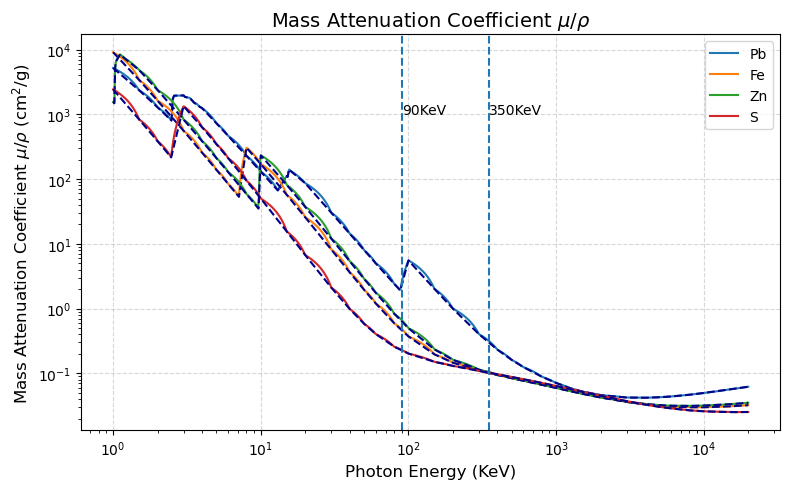

In [48]:
plot_mu_rho_vs_energy(['Pb', 'Fe', 'Zn', 'S'])

## interpolate to dual energies

In [51]:
Es = [90, 350]
mu = [[], []]
for symbol in ['Fe', 'S', 'Zn', 'Pb', 'Si', 'O']:
    for i, e in enumerate(Es):
        _, _, mu_e = get_mu_rho(symbol, e*1e-3)
        mu[i].append(mu_e)
    
# mu = np.array(mu)

In [48]:
mu

array([[0.48345   , 0.23025   , 0.66685   , 2.51536239, 0.20315   ,
        0.16145   ],
       [0.10195   , 0.102875  , 0.104745  , 0.3177    , 0.10217   ,
        0.10133   ]])

## fake data 

In [54]:
pixels[1][0].shape

(1815,)

In [59]:
data


,Sample No.,Fe_grade,Zn_grade,Pb_grade,S_grade,weight,source,Zn_Pb_grade
0,1,30.130,0.031,0.063,34.83,39.9,source_0,0.094
1,2,7.446,0.784,2.125,6.72,50.4,source_0,2.909
2,3,30.480,0.058,0.045,31.65,69.8,source_0,0.103
3,4,31.200,0.089,0.319,31.76,48.8,source_0,0.408
4,5,9.662,10.170,1.353,11.81,48.7,source_0,11.523
...,...,...,...,...,...,...,...,...
399,196,28.230,0.337,19.820,0.00,36.3,source_2,20.157
400,197,6.561,33.460,10.980,0.00,20.9,source_2,44.440
401,198,10.780,17.140,0.245,0.00,34.8,source_2,17.385
402,199,2.860,6.540,1.090,0.00,68.6,source_2,7.630


In [ ]:
# 目标函数: ||Aw - b||^2
def objective(w, A, b):
    return np.sum((A @ w - b)**2) 



In [81]:

from scipy.optimize import nnls
from scipy.optimize import lsq_linear

elements = ['Fe', 'S', 'Zn', 'Pb', 'Si', 'O']
stone_i = 0
A1 = pixels[0].apply(np.mean)[stone_i]
A2 = pixels[1].apply(np.mean)[stone_i]
size = A1.size

# 1. 质量衰减系数矩阵 mu: shape (2, 6)，假设值（实际可查表）
mu = np.array(mu)
# 2. 元素-矿物质量关系矩阵 C: shape (6, 4)
# 矿物顺序：[FeS2, ZnS, PbS, SiO2]
ores = ['FeS2', 'ZnS', 'PbS', 'SiO2']
C = np.array([
    [55.85/119.99, 0, 0, 0],                   # Fe
    [64.14/119.99, 32.07/97.45, 32.07/239.27, 0],  # S
    [0, 65.38/97.45, 0, 0],                    # Zn
    [0, 0, 207.2/239.27, 0],                   # Pb
    [0, 0, 0, 28.09/60.09],                    # Si
    [0, 0, 0, 32.00/60.09],                    # O
])

# 3. 预计算 M 矩阵：shape (2, 4)
M = mu @ C

# 4. 反演每个像素的矿物质量分布（非负最小二乘法）
element_mass_total = np.zeros(6)  # [Fe, S, Zn, Pb, Si, O]
total_mass = 0.0

for i in range(size):
        A = np.array([A1, A2])
        # --------
        # m, _ = nnls(M, A)  # m: 4矿物质量

        # --------
        # m, residuals, rank, s = np.linalg.lstsq(M, A, rcond=None)

        # --------
        # bounds = (0, np.inf)  # 设置非负约束
        # result = lsq_linear(M, A, bounds=bounds)
        # m = result.x

        # --------
        # 边界: w_i >= 0
        bounds = [(0, None) for _ in ores]
        # 初始猜测
        w0 = np.ones(len(ores))  # 每个元素的初始猜测质量
        # 优化
        # 约束: sum(w) == M_total
        constraints = {
            'type': 'eq',
            'fun': lambda w: np.sum(w) - data['weight'][stone_i]
        }
        res = minimize(objective, w0, args=(M, A), method='SLSQP', bounds=bounds, constraints=[constraints])
        m = res.x
        # --------

        w = C @ m          # w: 6元素质量
        element_mass_total += w
        total_mass += np.sum(w)

# 5. 计算每种元素的品位

grades = element_mass_total / total_mass

# 6. 打印结果
for name, grade, mass in zip(elements, grades, element_mass_total):
    print(f"{name} grade: {grade:.4f}; total mass: {mass:.4f}")


Fe grade: 0.0000; total mass: 0.0000
S grade: 0.0663; total mass: 2.6465
Zn grade: 0.0000; total mass: 0.0000
Pb grade: 0.4285; total mass: 17.0986
Si grade: 0.2361; total mass: 9.4217
O grade: 0.2690; total mass: 10.7332


In [ ]:
Fe grade: 0.1760; total mass: 273169.7883
S grade: 0.2562; total mass: 397791.0860
Zn grade: 0.1468; total mass: 227887.2656
Pb grade: -0.1153; total mass: -179022.6681
Si grade: 0.2507; total mass: 389210.5370
O grade: 0.2856; total mass: 443386.8703

In [ ]:
Fe grade: 0.0000; total mass: 0.0000
S grade: 0.0000; total mass: 1.3034
Zn grade: 0.0000; total mass: 0.0000
Pb grade: 0.0000; total mass: 8.4211
Si grade: 0.4675; total mass: 282025.8546
O grade: 0.5325; total mass: 321282.5684

In [43]:
# 元素
elements = ['Fe', 'S', 'Pb', 'Zn']

# 测量能量
energies = np.array([20, 60])  # keV

# 真正的元素质量
true_masses = {
    'Fe': 30,
    'S': 20,
    'Zn': 4,
    'Pb': 6,
}

M_total = sum(true_masses.values())

# 获取 μ/ρ 矩阵
mu_rho_matrix = []
for elem in elements:
    _, _, mu_rho = get_mu_rho(elem, energies*1e-3)
    mu_rho_matrix.append(mu_rho)
mu_rho_matrix = np.array(mu_rho_matrix)  # shape (n_elements, n_energies)

# 构造总吸收量
measured_absorption = np.sum([
    true_masses[elem] * mu_rho
    for elem, mu_rho in zip(elements, mu_rho_matrix)
], axis=0)

print("[+] 伪观测吸收数据:", measured_absorption)

# -------------------------
# 用 nnls 反推元素质量
# -------------------------

# 注意：nnls要求 A 的形状是 (n_measurements, n_variables)
Mu = mu_rho_matrix.T  # 转置，形状：(n_energies, n_elements)
Mu_aug = np.vstack([Mu, np.ones((1, len(elements)))])


# b 是观测的吸收数据
b = measured_absorption
b_aug = np.hstack([b, M_total])

# 调用 nnls
# w_estimated, rnorm = nnls(Mu_aug, b_aug)

# 求解最小二乘解
# measured_absorption = A @ w
# → w = (A^T A)^-1 A^T b

w_estimated_0, residuals, rank, s = np.linalg.lstsq(Mu, b, rcond=None)

w_estimated_1, residuals, rank, s = np.linalg.lstsq(Mu_aug, b_aug, rcond=None)


# -------------------------
# 定义优化
# -------------------------

# 目标函数: ||Aw - b||^2
def objective(w):
    return np.sum((Mu @ w - b)**2) 
# 约束: sum(w) == M_total
constraints = {
    'type': 'eq',
    'fun': lambda w: np.sum(w) - M_total
}
# 边界: w_i >= 0
bounds = [(0, None) for _ in elements]
# 初始猜测
w0 = np.ones(len(elements)) * (M_total / len(elements))
# 优化
res = minimize(objective, w0, method='SLSQP', bounds=bounds, constraints=[constraints])
w_estimated = res.x

print("[+] 使用minimize, lstsq, no weight_constraint 反推出的元素质量：")
for elem, mass, mass_1, mass_0 in zip(elements, w_estimated, w_estimated_1, w_estimated_0):
    print(f"{elem}: {mass:.2f}, {mass_1:.2f}, {mass_0:.2f} g (真实 {true_masses[elem]} g)")

print(f"推算出的总质量: {np.sum(w_estimated):.2f}, {np.sum(w_estimated_1):.2f}, {np.sum(w_estimated_0):.2f} g (真实 {M_total} g)")

# 计算各方法估算值与真实值的平方和
sse_estimated = np.sum((w_estimated - np.array([true_masses[e] for e in elements]))**2)
sse_estimated_1 = np.sum((w_estimated_1 - np.array([true_masses[e] for e in elements]))**2)
sse_estimated_0 = np.sum((w_estimated_0 - np.array([true_masses[e] for e in elements]))**2)

print(f"\n[+] 各方法估算值与真实值的平方和：")
print(f"minimize with constraint: {sse_estimated:.2f}")
print(f"lstsq with constraint: {sse_estimated_1:.2f}")
print(f"lstsq without constraint: {sse_estimated_0:.2f}")

[+] 伪观测吸收数据: [1571.48    81.422]
[+] 使用minimize, lstsq, no weight_constraint 反推出的元素质量：
Fe: 14.55, 17.06, 11.65 g (真实 30 g)
S: 24.83, 24.04, 0.10 g (真实 20 g)
Pb: 5.38, 5.48, 7.67 g (真实 6 g)
Zn: 15.25, 13.42, 16.38 g (真实 4 g)
推算出的总质量: 60.00, 60.00, 35.80 g (真实 60 g)

[+] 各方法估算值与真实值的平方和：
minimize with constraint: 388.85
lstsq with constraint: 272.80
lstsq without constraint: 889.02
